Importing the required libraries

In [ ]:
import pandas as pd
import os
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

Loading the dataset and checking the first few rows

In [2]:
# Download and get the file name
path = kagglehub.dataset_download("alfathterry/telco-customer-churn-11-1-3")
file_name = os.listdir(path)[0] 

# Create the DataFrame
df = pd.read_csv(f"{path}/{file_name}")

# Check the result
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 50 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Under 30                           7043 non-null   object 
 4   Senior Citizen                     7043 non-null   object 
 5   Married                            7043 non-null   object 
 6   Dependents                         7043 non-null   object 
 7   Number of Dependents               7043 non-null   int64  
 8   Country                            7043 non-null   object 
 9   State                              7043 non-null   object 
 10  City                               7043 non-null   object 
 11  Zip Code                           7043 non-null   int64

In [3]:
df.describe()

,Age,Number of Dependents,Zip Code,Latitude,Longitude,Population,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score,Churn Score,CLTV
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,46.509726,0.468692,93486.070567,36.197455,-119.756684,22139.603294,1.951867,32.386767,22.958954,20.515405,64.761692,2280.381264,1.962182,6.860713,749.099262,3034.379056,3.244924,58.505040,4400.295755
std,16.750352,0.962802,1856.767505,2.468929,2.154425,21152.392837,3.001199,24.542061,15.448113,20.418940,30.090047,2266.220462,7.902614,25.104978,846.660055,2865.204542,1.201657,21.170031,1183.057152
min,19.000000,0.000000,90001.000000,32.555828,-124.301372,11.000000,0.000000,1.000000,0.000000,0.000000,18.250000,18.800000,0.000000,0.000000,0.000000,21.360000,1.000000,5.000000,2003.000000
25%,32.000000,0.000000,92101.000000,33.990646,-121.788090,2344.000000,0.000000,9.000000,9.210000,3.000000,35.500000,400.150000,0.000000,0.000000,70.545000,605.610000,3.000000,40.000000,3469.000000
50%,46.000000,0.000000,93518.000000,36.205465,-119.595293,17554.000000,0.000000,29.000000,22.890000,17.000000,70.350000,1394.550000,0.000000,0.000000,401.440000,2108.640000,3.000000,61.000000,4527.000000
75%,60.000000,0.000000,95329.000000,38.161321,-117.969795,36125.000000,3.000000,55.000000,36.395000,27.000000,89.850000,3786.600000,0.000000,0.000000,1191.100000,4801.145000,4.000000,75.500000,5380.500000
max,80.000000,9.000000,96150.000000,41.962127,-114.192901,105285.000000,11.000000,72.000000,49.990000,85.000000,118.750000,8684.800000,49.790000,150.000000,3564.720000,11979.340000,5.000000,96.000000,6500.000000


In [4]:
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_")
)

In [5]:
drop_cols = [
    "customer_id",
    "zip_code",
    "latitude",
    "longitude"
]

df = df.drop(columns=drop_cols)

print(df.shape)


(7043, 46)


In [6]:
num_cols = [
    "monthly_charge",
    "total_charges",
    "total_revenue",
    "cltv",
    "avg_monthly_long_distance_charges"
]

for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")


In [7]:
binary_cols = [
    "under_30",
    "senior_citizen",
    "married",
    "paperless_billing",
    "referred_a_friend"
]

for col in binary_cols:
    df[col] = df[col].map({"Yes":1, "No":0})


In [8]:
df.isnull().sum().sort_values(ascending=False)

churn_reason                         5174
churn_category                       5174
offer                                3877
internet_type                        1526
monthly_charge                          0
streaming_tv                            0
streaming_movies                        0
streaming_music                         0
unlimited_data                          0
contract                                0
paperless_billing                       0
payment_method                          0
total_charges                           0
device_protection_plan                  0
total_refunds                           0
total_extra_data_charges                0
total_long_distance_charges             0
total_revenue                           0
satisfaction_score                      0
customer_status                         0
churn_label                             0
churn_score                             0
cltv                                    0
premium_tech_support              

In [9]:
leakage_cols = [
    "churn_category",
    "churn_reason",
    "churn_score",
    "customer_status"
]

df_model = df.drop(columns=leakage_cols)


In [10]:
df.describe(percentiles=[0.01, 0.99])
df["churn_label"].value_counts(normalize=True) * 100
df.to_csv("cleaned_telecom_churn.csv", index=False)

In [11]:
df_new=pd.read_csv("D:/Projects/telecom-churn/cleaned_telecom_churn.csv")

<Axes: xlabel='churn_label', ylabel='tenure_in_months'>

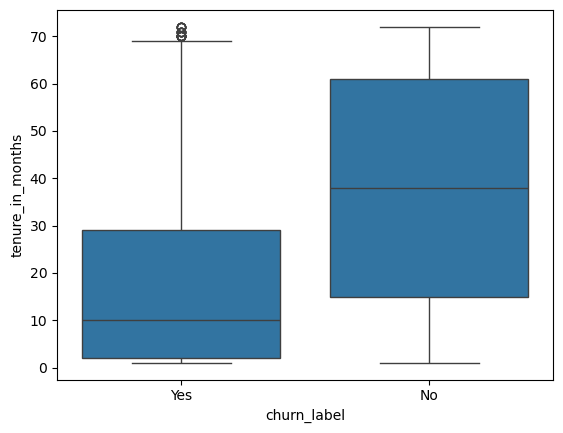

In [12]:
df_new.groupby("churn_label")["tenure_in_months"].mean()
sns.boxplot(x="churn_label", y="tenure_in_months", data=df_new)

In [13]:
pd.crosstab(
    df_new["contract"],
    df_new["churn_label"],
    normalize="index"
)


churn_label,No,Yes
contract,,
Month-to-Month,0.541551,0.458449
One Year,0.892903,0.107097
Two Year,0.974509,0.025491


In [14]:
df_new.groupby("churn_label")["monthly_charge"].mean()

churn_label
No     61.265124
Yes    74.441332
Name: monthly_charge, dtype: float64

In [15]:
df_new.groupby("churn_label")["satisfaction_score"].mean()

churn_label
No     3.789911
Yes    1.736223
Name: satisfaction_score, dtype: float64

In [16]:
df_new.groupby("churn_label")["avg_monthly_gb_download"].median()

churn_label
No     16.0
Yes    19.0
Name: avg_monthly_gb_download, dtype: float64

In [17]:
df_new.groupby("churn_label")["cltv"].mean()

churn_label
No     4490.921337
Yes    4149.414660
Name: cltv, dtype: float64

In [18]:
df_new["tenure_segment"] = pd.cut(
    df_new["tenure_in_months"],
    bins=[0, 12, 24, 48, 72],
    labels=["0-1yr", "1-2yr", "2-4yr", "4-6yr"]
)
pd.crosstab(
    df_new["tenure_segment"],
    df_new["churn_label"],
    normalize="index"
)


churn_label,No,Yes
tenure_segment,,
0-1yr,0.525618,0.474382
1-2yr,0.712891,0.287109
2-4yr,0.796110,0.203890
4-6yr,0.904868,0.095132


Business question:
Are customers with higher monthly charges more likely to churn?

In [19]:
churned = df_new[df_new["churn_label"]=="Yes"]["monthly_charge"]
not_churned = df_new[df_new["churn_label"]=="No"]["monthly_charge"]

ttest_ind(churned, not_churned, equal_var=False)

TtestResult(statistic=18.407526676414655, pvalue=8.592449331549745e-73, df=4135.795017764659)

There is an overwhelming, statistically undeniable difference between the two groups which was compared.

Business question: Do early-tenure customers churn more?

In [20]:
churned = df_new[df_new["churn_label"]=="Yes"]["tenure_in_months"]
not_churned = df_new[df_new["churn_label"]=="No"]["tenure_in_months"]

ttest_ind(churned, not_churned, equal_var=False)


TtestResult(statistic=-34.87636868308526, pvalue=3.157743884676685e-233, df=4043.3386881640185)

Early churn is statistically significant → onboarding failure.

Business question:
Is satisfaction a stronger churn driver than price?

In [21]:
churned = df_new[df_new["churn_label"]=="Yes"]["satisfaction_score"]
not_churned = df_new[df_new["churn_label"]=="No"]["satisfaction_score"]

ttest_ind(churned, not_churned, equal_var=False)


TtestResult(statistic=-94.96694169823348, pvalue=0.0, df=3208.609473496411)

If satisfaction is significant → fix experience, not discounts.

Business question:
Does contract type influence churn?

In [22]:
table = pd.crosstab(df_new["contract"], df_new["churn_label"])
chi2_contingency(table)


Chi2ContingencyResult(statistic=1445.2932428377585, pvalue=0.0, dof=2, expected_freq=array([[2652.01476643,  957.98523357],
       [1138.67670027,  411.32329973],
       [1383.3085333 ,  499.6914667 ]]))

Push long-term plans to high-risk users

Churn Model

In [23]:
y = df_new["churn_label"].map({"Yes": 1, "No": 0})


In [24]:
drop_cols = [
    "churn_label",
    "churn_category",
    "churn_reason",
    "customer_status",
    "churn_score",
    "customer_id"
]

X = df_new.drop(columns=[c for c in drop_cols if c in df_new.columns])


In [25]:
X = pd.get_dummies(X, drop_first=True)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [28]:
lr = LogisticRegression(max_iter=1000, class_weight="balanced")
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.88      0.92      1294
           1       0.73      0.90      0.81       467

    accuracy                           0.88      1761
   macro avg       0.84      0.89      0.86      1761
weighted avg       0.90      0.88      0.89      1761

ROC-AUC: 0.95955141337552
[[1137  157]
 [  46  421]]


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight="balanced",
    random_state=42
)
rf.fit(X_train, y_train)

rf_proba = rf.predict_proba(X_test)[:,1]
print("RF ROC-AUC:", roc_auc_score(y_test, rf_proba))


RF ROC-AUC: 0.964125315655521


In [30]:
importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False)

importance.head(10)

,feature,importance
18,satisfaction_score,0.245019
7,number_of_referrals,0.059476
1145,contract_Two Year,0.055451
8,tenure_in_months,0.047258
12,monthly_charge,0.041892
1150,tenure_segment_4-6yr,0.037618
17,total_revenue,0.031986
16,total_long_distance_charges,0.031786
13,total_charges,0.031333
1135,internet_type_Fiber Optic,0.030238


Customer churn is driven more by experience and engagement than pricing alone, with satisfaction and tenure being the strongest stabilizing factors.